### setup

In [24]:
import argparse
import glob
import os
import pickle
import random
import shutil
import time

In [25]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler
import torchvision.transforms as transforms

#torch.backends.cudnn.benchmark=True

In [52]:
parser = {
    'train_path': '../data/train4320/',
    'train_masks_path': '../data/train4320_masks/',
    'val_path': '../data/val768/',
    'val_masks_path': '../data/val768_masks/',
    'test_path': '../data/test_hq/',
    'split_data': False,
    'batch_size': 2,
    'log_every': 10,
    'train': False,
    'model_name': 'model_20170915_epoch2_score0.99662.pth',
    'test': True,
    'seed': 20170915,
}
args = argparse.Namespace(**parser)

torch.manual_seed(args.seed)

args.intermediate_path = os.path.join('../intermediate/', str(args.seed), 'd')
if not os.path.isdir(args.intermediate_path):
    os.mkdir(args.intermediate_path)

In [28]:
if args.split_data:
    # !mogrify -format png *.gif
    if not os.path.isdir(args.train_path):
        os.mkdir(args.train_path)
    if not os.path.isdir(args.train_masks_path):
        os.mkdir(args.train_masks_path)
    if not os.path.isdir(args.val_path):
        os.mkdir(args.val_path)
    if not os.path.isdir(args.val_masks_path):
        os.mkdir(args.val_masks_path)
    files = sorted([x.split('/')[-1] for x in glob.glob('../data/train_hq/*.jpg')])
    random.seed(args.seed)
    random.shuffle(files)
    for filename in files[:4320]:
        image = cv2.imread('../data/train_hq/' + filename)
        image = cv2.resize(image, (1024, 1024))
        cv2.imwrite(os.path.join(args.train_path, filename), image)
        mask_filename = '../data/train_masks/' + filename.replace('.jpg', '_mask.png')
        shutil.copy2(mask_filename, args.train_masks_path)
    for filename in files[4320:]:
        image = cv2.imread('../data/train_hq/' + filename)
        image = cv2.resize(image, (1024, 1024))
        cv2.imwrite(os.path.join(args.val_path, filename), image)
        mask_filename = '../data/train_masks/' + filename.replace('.jpg', '_mask.png')
        shutil.copy2(mask_filename, args.val_masks_path)

### model

In [29]:
class ConvBnRelu2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super(ConvBnRelu2d, self).__init__()
        padding = kernel_size//2 * dilation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              dilation=dilation, padding=padding, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels, eps=1e-4)

    def forward(self, x):
        o = self.conv(x)
        if self.bn is not None:
            o = self.bn(o)
        return F.relu(o)

    def merge_bn(self):  # for faster inference
        if self.bn is None:
            return
        
        conv_weight     = self.conv.weight.data
        bn_weight       = self.bn.weight.data
        bn_bias         = self.bn.bias.data
        bn_running_mean = self.bn.running_mean
        bn_running_var  = self.bn.running_var
        bn_eps          = self.bn.eps

        N,C,H,W = conv_weight.size()
        std = torch.sqrt(bn_running_var+bn_eps)
        std_bn_weight = (bn_weight/std).repeat(C*H*W,1).t().contiguous().view(N,C,H,W)
        conv_weight_hat = std_bn_weight*conv_weight
        conv_bias_hat   = bn_bias - (bn_weight/std)*bn_running_mean
        
        self.conv = nn.Conv2d(self.conv.in_channels, self.conv.out_channels, self.conv.kernel_size,
                              padding=self.conv.padding, bias=True)
        self.conv.weight.data = conv_weight_hat
        self.conv.bias.data   = conv_bias_hat
        self.bn = None

In [30]:
class StackEncoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(StackEncoder, self).__init__()
        self.encode = nn.Sequential(
            ConvBnRelu2d(in_channels, out_channels, kernel_size),
            ConvBnRelu2d(out_channels, out_channels, kernel_size, dilation=2))

    def forward(self, x):
        e = self.encode(x)
        o = F.max_pool2d(e, kernel_size=2, stride=2)
        return e, o

In [31]:
class StackDecoder(nn.Module):
    
    def __init__(self, en_channels, in_channels, out_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = nn.Sequential(
            ConvBnRelu2d(en_channels+out_channels, out_channels, kernel_size=kernel_size),
#            ConvBnRelu2d(out_channels, out_channels, kernel_size=kernel_size),
            ConvBnRelu2d(out_channels, out_channels, kernel_size=kernel_size))

    def forward(self, e, x):
        N,C,H,W = e.size()
        x = self.upsample(x)
#        x = F.upsample(x, size=(H,W), mode='bilinear')
        x = torch.cat([e, x], dim=1)
        return self.decode(x)

In [32]:
class UNet1024(nn.Module):
    
    def __init__(self, in_shape):
        super(UNet1024, self).__init__()
        C,H,W = in_shape

        # 1024
        self.down1 = StackEncoder(  C,  32)  # 512
        self.down2 = StackEncoder( 32,  64)  # 256
        self.down3 = StackEncoder( 64, 128)  # 128
        self.down4 = StackEncoder(128, 256)  # 64
        self.down5 = StackEncoder(256, 512)  # 32
#        self.down6 = StackEncoder(2048, 768)  # 16

        self.center = nn.Sequential(
            ConvBnRelu2d( 512, 1024, kernel_size=3, dilation=1),
            ConvBnRelu2d(1024, 1024, kernel_size=3, dilation=2),
            ConvBnRelu2d(1024, 1024, kernel_size=3, dilation=4),
            ConvBnRelu2d(1024, 1024, kernel_size=3, dilation=8),
            ConvBnRelu2d(1024, 1024, kernel_size=3, dilation=16))

        # 16
#        self.up6 = StackDecoder(768, 768, 512)  # 32
        self.up5 = StackDecoder(512, 1024, 512)  # 64
        self.up4 = StackDecoder(256,  512, 256)  # 128
        self.up3 = StackDecoder(128,  256, 128)  # 256
        self.up2 = StackDecoder( 64,  128,  64)  # 512
        self.up1 = StackDecoder( 32,   64,  32)  # 1024
        
        self.mask = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        e1, o = self.down1(x)
        e2, o = self.down2(o)
        e3, o = self.down3(o)
        e4, o = self.down4(o)
        e5, o = self.down5(o)
#        e6, o = self.down6(o)

        o = self.center(o)
        
#        o = self.up6(e6, o)
        o = self.up5(e5, o)
        o = self.up4(e4, o)
        o = self.up3(e3, o)
        o = self.up2(e2, o)
        o = self.up1(e1, o)

        o = self.mask(o)
        o = F.upsample(o, size=(1280,1918), mode='bilinear')
        return torch.squeeze(o, dim=1)

### utils

In [33]:
def dice_score(probs, target, weight=None, use_mask=True, threshold=0.5):
    if use_mask:
        probs = (probs > threshold).float()
    N     = target.size(0)
    if weight is None:
        w = Variable(torch.ones(target.size()).cuda()).view(N, -1)
    else:
        w = weight.view(N, -1)
    w2    = w*w
    m1    = probs.view(N, -1)
    m2    = target.view(N, -1)
    score = (2*(w2*m1*m2).sum(dim=1) + 1) / ((w2*m1).sum(dim=1) + (w2*m2).sum(dim=1) + 1)
    
    return score.sum()/N


def dice_loss(logits, target, weight=None):
    probs = F.sigmoid(logits)
    loss  = 1 - dice_score(probs, target, weight, use_mask=False)
    
    return loss


def criterion(logits, target):
    N,H,W = target.size()
    a = F.avg_pool2d(target, kernel_size=41, stride=1, padding=20)
    boundary = (a.ge(0.01) * a.le(0.99)).float()
    weight = Variable(torch.ones(a.size()).cuda())
    w0 = weight.sum()
    weight = weight + 2*boundary
    w1 = weight.sum()
    weight = weight*w0/w1
        
    return (F.binary_cross_entropy_with_logits(logits, target, weight),
            dice_loss(logits, target, weight))

In [34]:
def image_to_tensor(image):
    image = image.transpose((2,0,1)).astype(np.float32)  # HWC -> CHW
    tensor = torch.from_numpy(image)
    return tensor


def label_to_tensor(label, threshold=0.5):
    label  = (label>threshold).astype(np.float32)
    tensor = torch.from_numpy(label)
    return tensor

In [59]:
class CarDataset(Dataset):

    def __init__(self, image_path, mask_path='', transform=[], mode='train'):
        super(CarDataset, self).__init__()
        self.img_names = sorted([x.split('/')[-1] for x in glob.glob(image_path + '/*.jpg')])
        self.img_path  = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.mode      = mode

    def get_image(self, index):
        name  = self.img_names[index]
        file  = os.path.join(self.img_path, name)
        img   = cv2.imread(file)
        img = cv2.resize(img, (1024, 1024))
        image = img / 255
        return image, name
    
    def get_label(self, name):
        name = name.replace('.jpg', '_mask.png')
        file = os.path.join(self.mask_path, name)
        mask = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        label = mask / 255
        return label

    def get_train_item(self, index):
        image, name = self.get_image(index)
        label = self.get_label(name)
        image = image_to_tensor(image)
        label = label_to_tensor(label)
        return image, label

    def get_test_item(self, index):
        image, _ = self.get_image(index)
        image = image_to_tensor(image)
        return image

    def __getitem__(self, index):
        if self.mode == 'train':
            return self.get_train_item(index)
        elif self.mode == 'test':
            return self.get_test_item(index)

    def __len__(self):
        return len(self.img_names)

In [36]:
def train(train_loader, model, optimizer):
    num_grad_acc = 16 // args.batch_size
    model.train()
    train_bce_loss = 0
    train_score = 0
    init_time = time.time()
    optimizer.zero_grad()
    for i, (inputt, target) in enumerate(train_loader, 1):
        inputt = inputt.cuda()
        target = target.cuda()
        inputt = Variable(inputt)
        target = Variable(target)
        
        output = model(inputt)
        bce_loss, dice_loss = criterion(output, target)
        loss = bce_loss + dice_loss
        loss.backward()
        if i % num_grad_acc == 0:
            nn.utils.clip_grad_norm(model.parameters(), 3, 'inf')
            optimizer.step()
            optimizer.zero_grad()
        train_bce_loss += bce_loss.data[0] * inputt.size(0)
        train_score += (1-dice_loss).data[0] * inputt.size(0)
        if i % args.log_every == 0:
            print("   % Time: {:4.0f}s | Batch: {:4} | "
                  "Train bce loss: {:.5f} | Train score: {:.5f}"
                  .format(time.time()-init_time, i,
                          bce_loss.data[0], (1-dice_loss).data[0]))
    return (train_bce_loss / len(train_loader.dataset),
            train_score / len(train_loader.dataset))

In [37]:
def validate(val_loader, model):
    model.eval()
    val_score = 0
    for i, (inputt, target) in enumerate(val_loader, 1):
        inputt = inputt.cuda()
        target = target.cuda()
        inputt = Variable(inputt, volatile=True)
        target = Variable(target)
        
        output = model(inputt)
        score = dice_score(F.sigmoid(output), target)
        val_score += score.data[0] * inputt.size(0)
    return val_score / len(val_loader.dataset)

In [38]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.intermediate_path,
                              "model_{}_epoch{}_score{:.5f}.pth"
                              .format(args.seed, epoch, score))
    torch.save(model.state_dict(), model_file)

In [39]:
def load_model(model, model_name):
    model_path = os.path.join(args.intermediate_path, model_name)
    assert os.path.isfile(model_path), 'Error: no model found!'
    model_state = torch.load(model_path)
    model.load_state_dict(model_state)

In [40]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [75]:
def test(test_loader, model, threshold=0.5):
    model.eval()
    init_time = time.time()
    list_rle = []
    for i, imgs in enumerate(test_loader, 1):
        imgs = imgs.cuda()
        imgs = Variable(imgs, volatile= True)
        outputs = model(imgs)
        outputs = outputs > threshold
        plt.figure(figsize=(10, 10))
        plt.imshow(imgs[0, :, :, :].data.cpu().numpy().transpose((1, 2, 0)))
        plt.show()
        plt.figure(figsize=(13,19))
        plt.imshow(outputs[0, :, :].data.cpu().numpy(), cmap='gray')
        plt.show()
        if i == 10:
            break
#        for j in range(outputs.size(0)):
#            rle = rle_encode(outputs[j, :, :].data.cpu().numpy())
#            list_rle.append(' '.join(str(x) for x in rle))
            
        if i % args.log_every == 0:
            print("   % Time: {:4.0f}s | Image: {:6d} / {}"
                  .format(time.time()-init_time, i*args.batch_size,
                          len(test_loader.dataset)))
    return list_rle

### prepare

In [42]:
train_dataset = CarDataset(args.train_path, args.train_masks_path,
                           transform=[], mode='train')
train_loader  = DataLoader(train_dataset, args.batch_size, shuffle=True, num_workers=7)

In [43]:
val_dataset = CarDataset(args.val_path, args.val_masks_path,
                         transform=[], mode='train')
val_loader  = DataLoader(val_dataset, args.batch_size, num_workers=7)

In [44]:
model = UNet1024((3, 1024, 1024))
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = MultiStepLR(optimizer, milestones=[10])

### train

In [45]:
if args.train:
    load_model(model, args.model_name)
    for epoch in range(1, 21):
        scheduler.step()
        print("=> EPOCH {} with lr {}".format(epoch, scheduler.get_lr()))
        init_time = time.time()
        train_bce_loss, train_score = train(train_loader, model, optimizer)
        val_score = validate(val_loader, model)
        print("="*10)
        print("   % Time: {:4.0f}s | Epoch: {:4} | "
              "Train bce loss: {:.5f} | Train score: {:.5f} | Val score: {:.5f}"
              .format(time.time()-init_time, epoch, train_bce_loss, train_score, val_score))
        print("="*10)
        save_model(model, epoch, val_score)
else:
    load_model(model, args.model_name)

In [64]:
test_dataset = CarDataset(args.test_path, transform=[], mode='test')
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

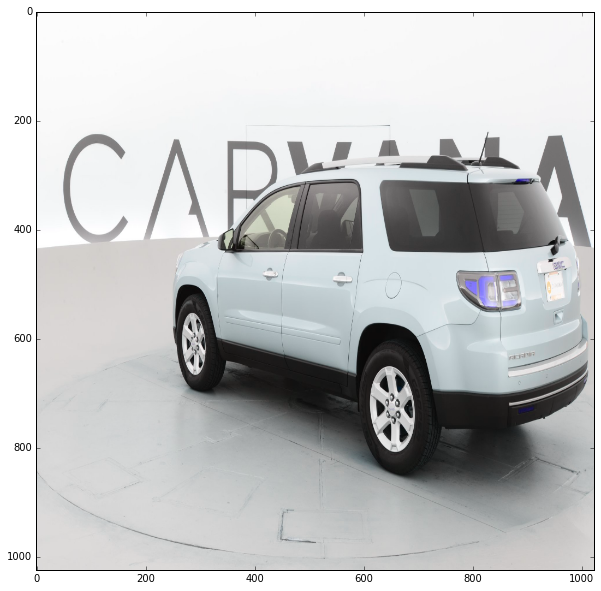

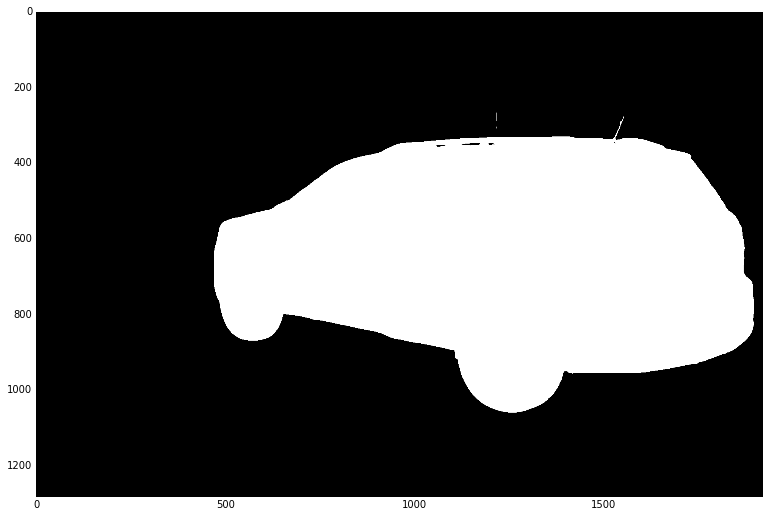

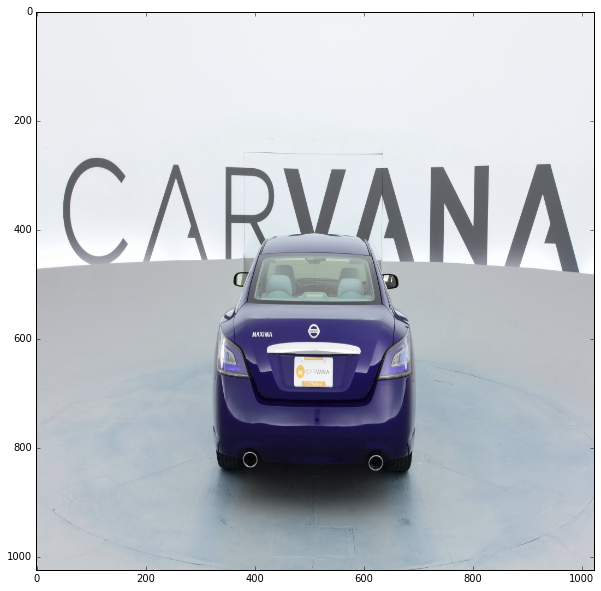

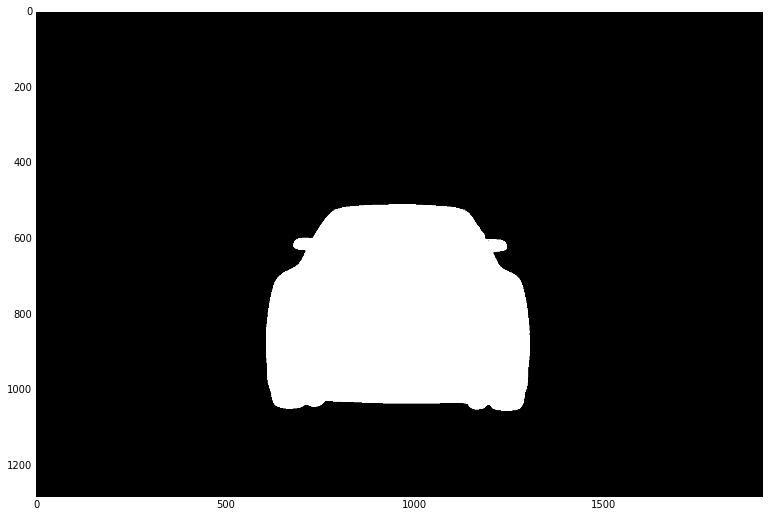

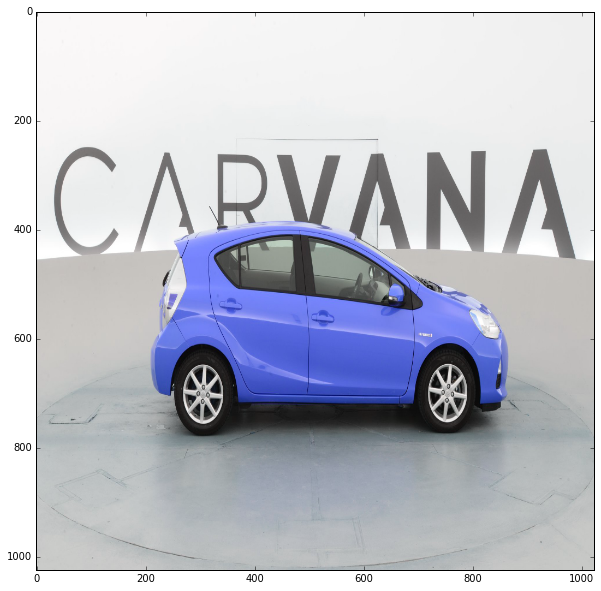

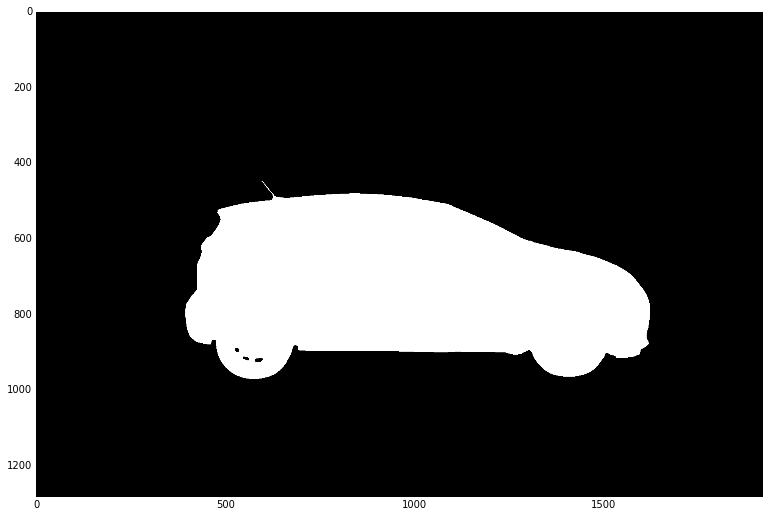

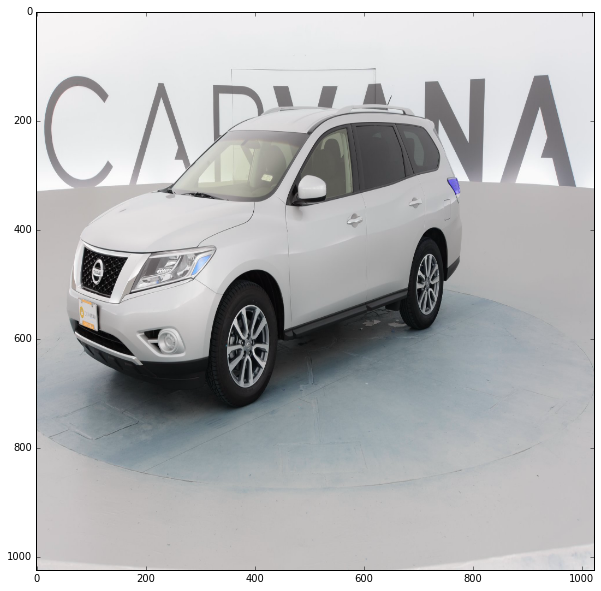

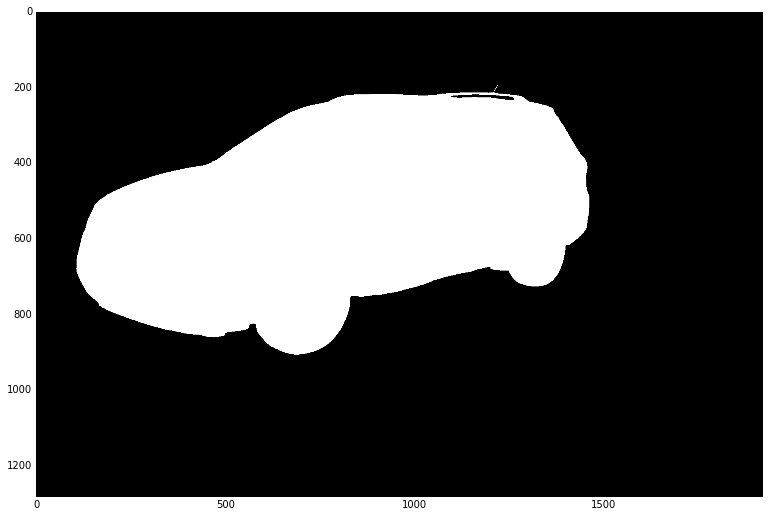

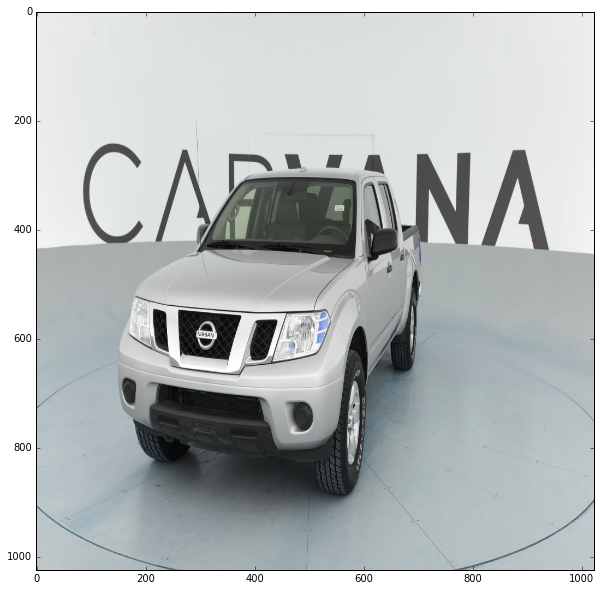

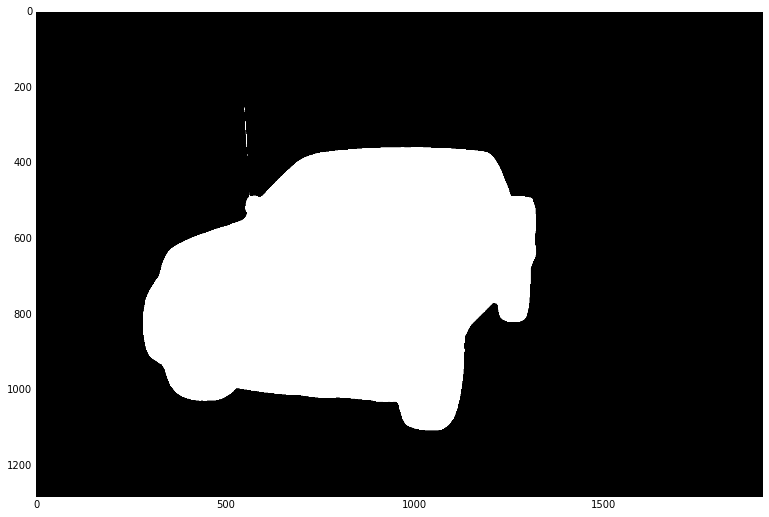

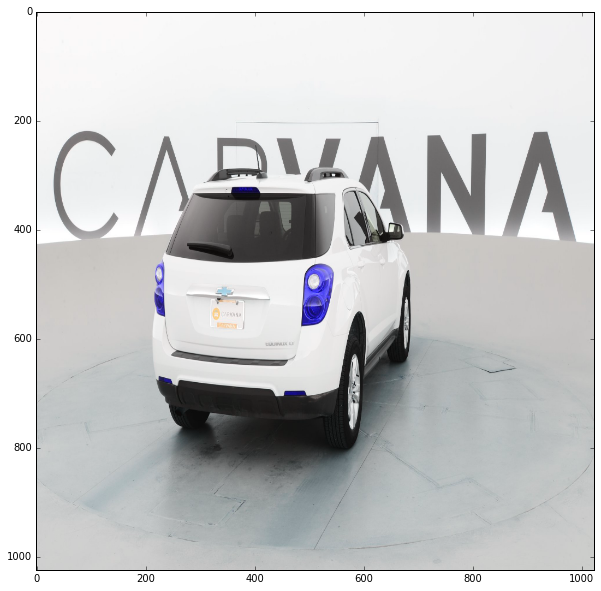

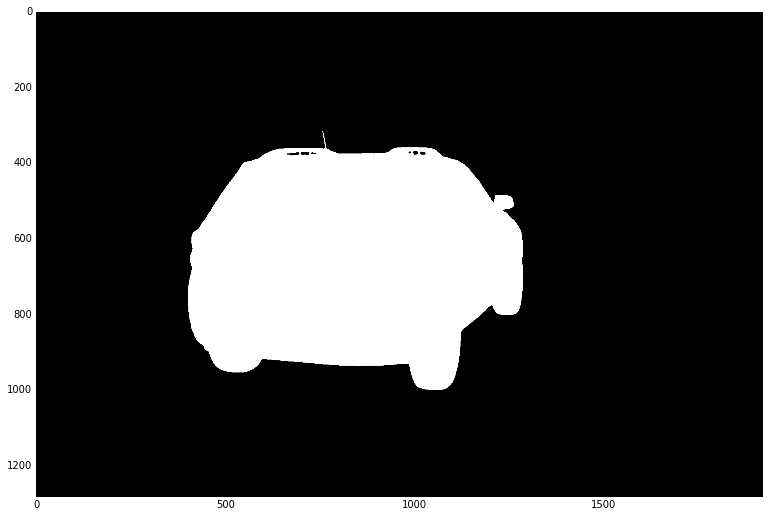

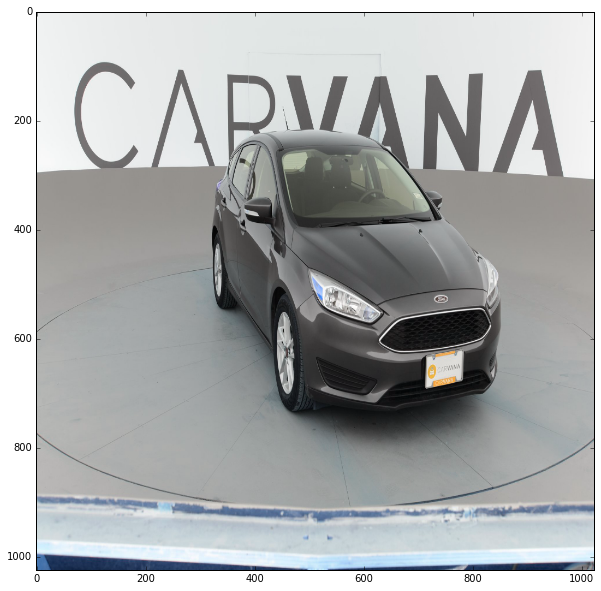

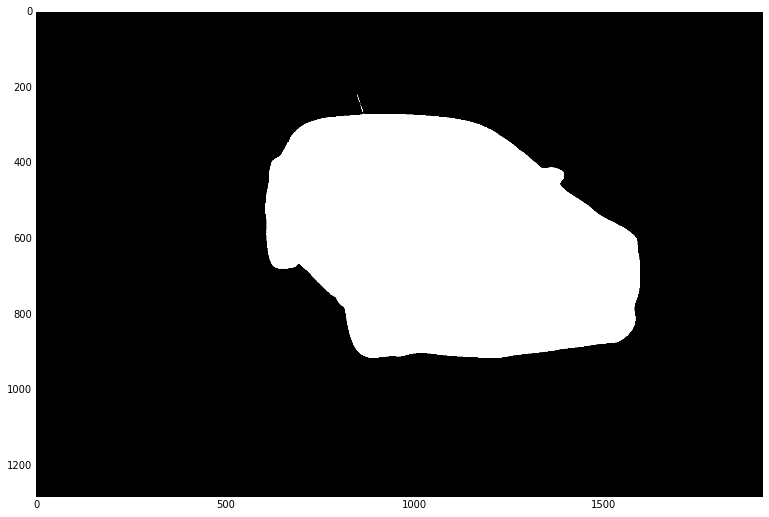

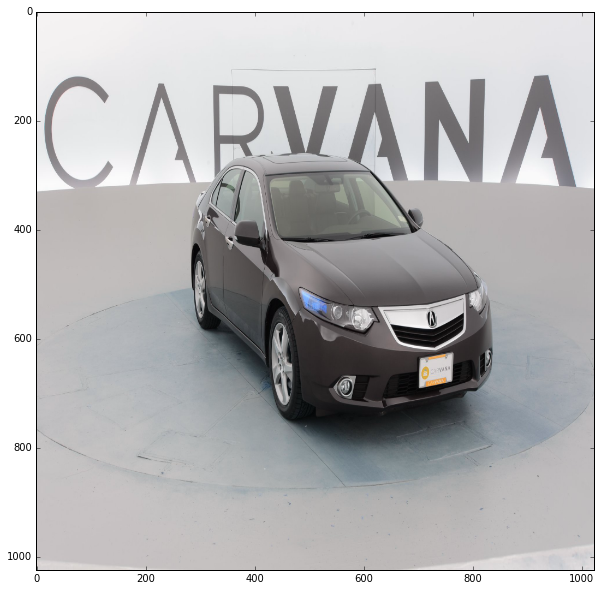

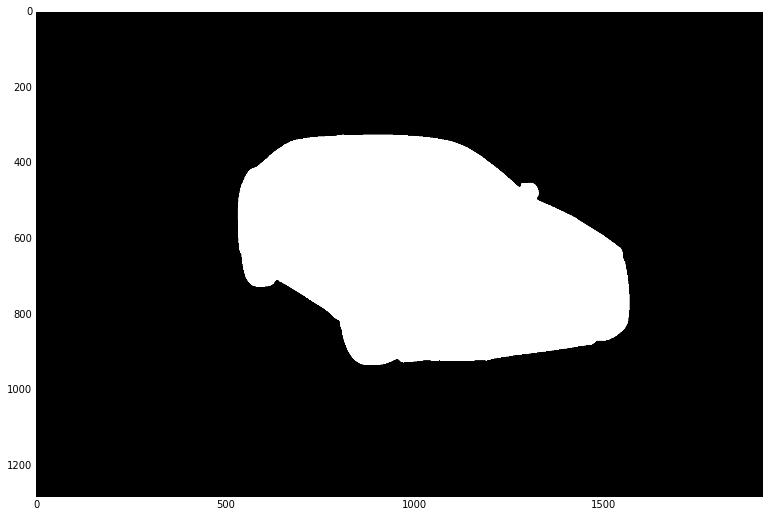

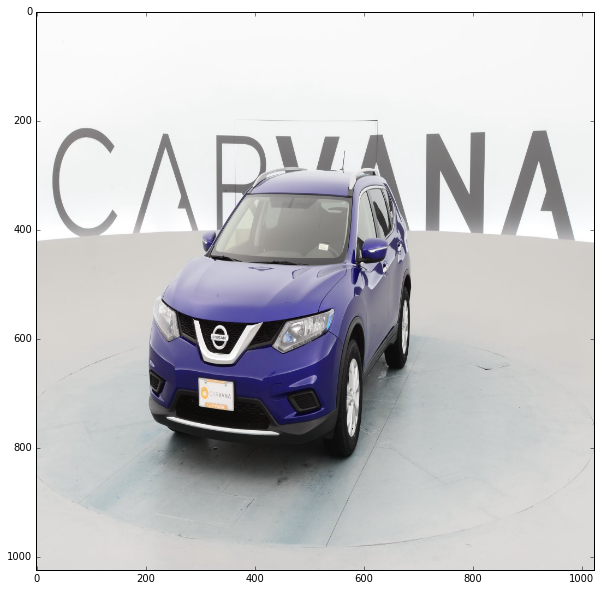

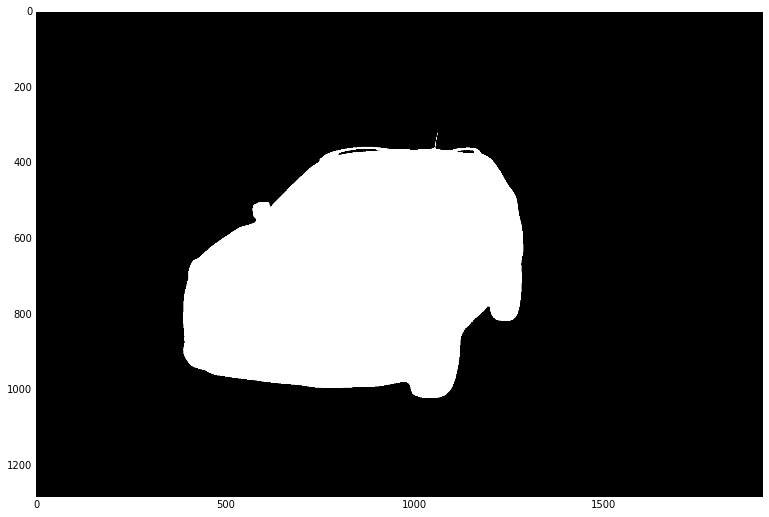

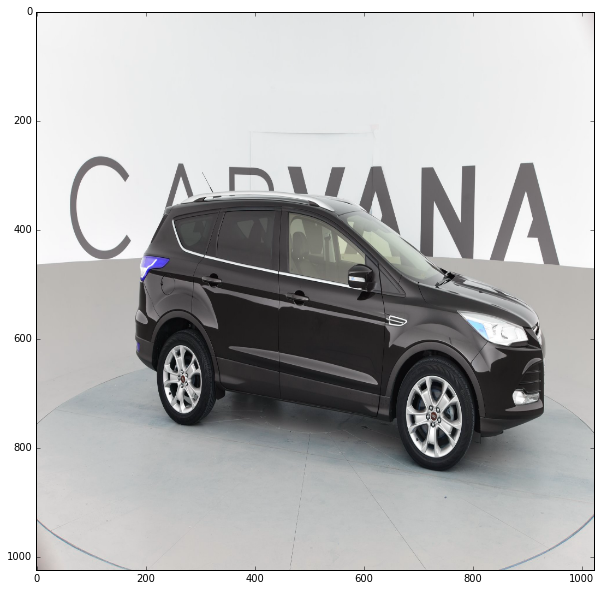

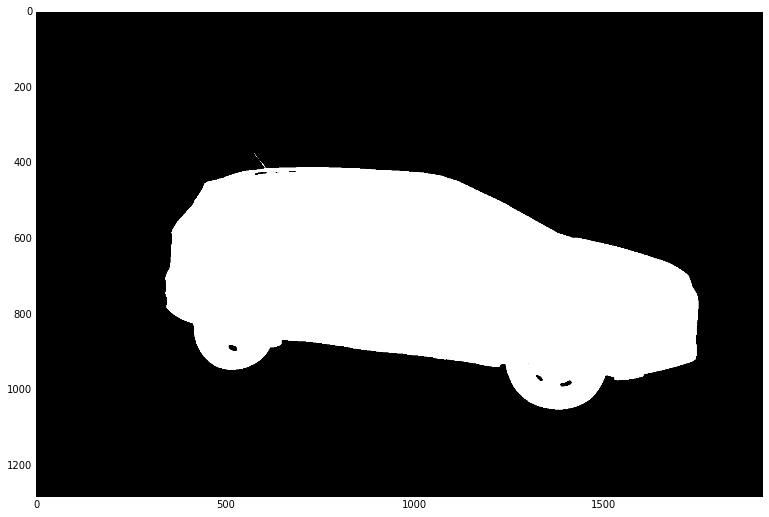

In [76]:
if args.test:
    list_rle = test(test_loader, model)
    
#    df = pd.DataFrame({"img": test_dataset.img_names, "rle_mask": list_rle})
#    submiss_path = os.path.join(args.intermediate_path, "submission.csv")
#    df.to_csv(submiss_path, index=False)

In [74]:
np.random.rand(3, 1024, 1025).transpose((1, 2, 0)).shape

(1024, 1025, 3)